In [1]:
import pandas as pd
import re
import io
import numpy as np
import math
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import TruncatedSVD 
from sklearn import metrics
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import matplotlib

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/miguel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
data = pd.read_csv('../data/raw/Unique2.csv', encoding='ISO-8859-1')

In [3]:
data

,Person_Name,Type,Email,Time_Working,Time_Night,Deleted_Email,Number_Sent,Subject,Forward,Reply,...,n_nonasciis,n_puncts,n_capsp,n_charsperword,sent_afinn,sent_bing,sent_syuzhet,sent_vader,n_polite,n_first_person
0,allen-p,1,Message-ID: <23575828.1075855684609.JavaMail.e...,0,0,0,1,Subject: Re: #30\r,0,1,...,0,0,1.000000,0.500000,0,0,0.00,0.0,0.000000,0
1,allen-p,1,Message-ID: <32509083.1075855684990.JavaMail.e...,0,0,0,1,Subject: \r,0,0,...,0,0,0.016393,6.100000,0,0,0.00,0.0,0.000000,0
2,grigsby-m,1,Message-ID: <1544302.1075855616699.JavaMail.ev...,0,0,0,1,Subject: http://ecthou-webcl1.nt.ect.enron.com...,0,0,...,0,0,0.018868,6.625000,0,0,0.00,0.0,0.000000,0
3,wolfe-j,0,Message-ID: <1706809.1075852553716.JavaMail.ev...,0,0,0,3,"\tmisty.robinson@enform.com, lindner@enron.com...",0,0,...,0,0,0.040000,8.333333,0,0,0.00,0.0,0.000000,0
4,dorland-c,2,Message-ID: <9883920.1075840404558.JavaMail.ev...,0,1,1,1,Subject: c4s\r,0,0,...,0,0,0.025641,4.875000,0,0,0.00,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55970,zipper-a,2,Message-ID: <20615901.1075845413238.JavaMail.e...,1,0,1,1,Subject: Mid-Year 2001 Performance Feedback\r,0,0,...,0,0,0.001880,5.782609,4,4,1.70,6.2,0.138889,0
55971,zipper-a,2,Message-ID: <12785528.1075845413191.JavaMail.e...,1,0,1,1,Subject: Mid-Year 2001 Performance Feedback\r,0,0,...,0,0,0.001876,5.670213,4,4,1.70,6.2,0.138889,0
55972,lucci-p,2,Message-ID: <27793565.1075855033802.JavaMail.e...,1,0,1,1,Subject: RE: Denver Travel Profiles/Arrangers\r,0,1,...,0,0,0.003322,5.016667,9,3,3.65,6.8,-0.375000,0
55973,corman-s,0,Message-ID: <11921647.1075861087999.JavaMail.e...,1,0,0,1,"Subject: Rebates, Reductions And More On HP PC...",0,0,...,0,0,0.000599,4.952522,22,12,15.20,25.0,-2.182540,0


In [4]:
# Reading dataset and extracting features and emails
# data = pd.ExcelFile("Unique2.xlsx")
# df = data.parse("Sheet 1")
df = data.dropna()
number_rows = 40000
df = df.iloc[list(range(0, number_rows)), :]

In [5]:
df

,Person_Name,Type,Email,Time_Working,Time_Night,Deleted_Email,Number_Sent,Subject,Forward,Reply,...,n_nonasciis,n_puncts,n_capsp,n_charsperword,sent_afinn,sent_bing,sent_syuzhet,sent_vader,n_polite,n_first_person
2,grigsby-m,1,Message-ID: <1544302.1075855616699.JavaMail.ev...,0,0,0,1,Subject: http://ecthou-webcl1.nt.ect.enron.com...,0,0,...,0,0,0.018868,6.625000,0,0,0.00,0.0,0.000,0
4,dorland-c,2,Message-ID: <9883920.1075840404558.JavaMail.ev...,0,1,1,1,Subject: c4s\r,0,0,...,0,0,0.025641,4.875000,0,0,0.00,0.0,0.000,0
9,crandell-s,0,Message-ID: <4758594.1075840060179.JavaMail.ev...,1,0,0,1,Subject: Holnam (Holcim)\r,0,0,...,0,0,0.010417,4.571429,5,2,1.50,5.2,0.500,0
10,schoolcraft-d,2,Message-ID: <10392304.1075852181625.JavaMail.e...,1,0,1,1,Subject: GALLUP STATION\r,0,0,...,0,0,0.004878,4.456522,4,1,0.55,1.2,-0.700,0
11,hayslett-r,2,Message-ID: <13461511.1075862272642.JavaMail.e...,1,0,1,3,Subject: RE: CAPEX\r,0,1,...,0,0,0.028571,4.375000,0,0,0.40,0.0,0.525,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48586,richey-c,0,Message-ID: <19890272.1075841468665.JavaMail.e...,0,0,0,1,Subject: FW: Excess Furniture\r,1,0,...,0,0,0.027027,4.625000,2,1,0.75,2.0,0.000,0
48587,tholt-j,1,Message-ID: <25625609.1075857497670.JavaMail.e...,0,0,0,1,Subject: Re: San Diego - Deal 341242\r,0,1,...,0,0,0.029412,4.250000,0,0,0.50,0.6,-0.500,0
48588,tholt-j,1,Message-ID: <18490912.1075857497691.JavaMail.e...,0,0,0,1,Subject: Re: San Diego - Deal 341242\r,0,1,...,0,0,0.038462,4.333333,0,0,0.25,0.0,0.000,0
48590,mims-thurston-p,0,Message-ID: <9845207.1075862119896.JavaMail.ev...,0,0,0,1,Subject: FW: Nicor Hub contracts\r,1,0,...,0,0,0.001610,5.645455,3,-2,3.65,3.7,-0.700,0


In [6]:
# Converting each document to array

documents = df['Cleaned_Email'].tolist()
tokenized_documents = []

for i in range(len(documents)):
  tokenized_documents.append(nltk.word_tokenize(documents[i]))

In [7]:
tokenized_documents[0]

['ctathamnavsetupindexhtm', 'pallen', 'westgasx', 'ect', 'research', 'page']

In [8]:
# Training (loading) doc2vec

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_documents)]

max_epochs = 10
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =0)
  
model.build_vocab(documents)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(documents,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

# model.save("dv.model_1")
# print("Model Saved")
# model= Doc2Vec.load("dv.model_1")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [9]:
# Converting documents to vector representation
X=[]
for doc in tokenized_documents:
    X.append(model.infer_vector(doc))

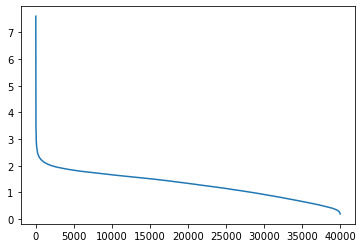

In [10]:
# Approach 1 - DB Scan on entire data
# DBScan parameter estimation

# Min_samples set to ln(number of points)
min_samples_set = int(math.ceil(math.log(number_rows)))
nbrs = NearestNeighbors(n_neighbors=min_samples_set).fit(X)
distances, indices = nbrs.kneighbors(X)
distanceDec = sorted(distances[:,min_samples_set-1], reverse=True)
plt.plot(list(range(1,number_rows + 1)), distanceDec)

In [11]:
# Performing DBScan

min_samples_set = int(math.ceil(math.log(number_rows)))
db = DBSCAN(eps=1.85, min_samples= min_samples_set).fit(X)
labels = db.labels_
print(np.unique(labels))
svd = TruncatedSVD(n_components = 2)
reduced_data = svd.fit_transform(X)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [12]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [13]:
def get_cluster_colors(labs):
    colors = []
    for i in labs:
        if i == -1:
            colors.append((0, 0, 0, 1))
        else:
            colors.append(plt.cm.Set1(float(i)/10))
    return colors

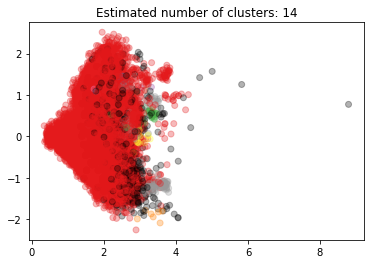

In [14]:
colors = get_cluster_colors(labels)
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=colors, alpha=0.3)
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [15]:
for i in range(3,11):
  km = KMeans(n_clusters= i)
  km.fit(X)
  clusters = km.labels_.tolist()
  print("Clusters: " + str(i) + " Score: " + str(metrics.silhouette_score(X, clusters, metric='euclidean')))

# Max for 5 clusters
km = KMeans(n_clusters= 5)
km.fit(X)
clusters = km.labels_.tolist()

Clusters: 3 Score: 0.07769087
Clusters: 4 Score: 0.06096132
Clusters: 5 Score: 0.07516634
Clusters: 6 Score: 0.062435254


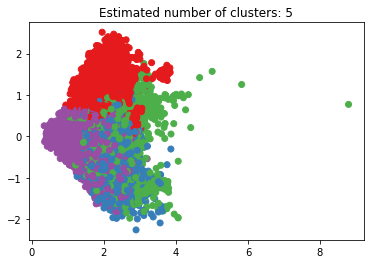

In [16]:
# Plotting KMeans
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=[plt.cm.Set1(float(i) /10) for i in clusters])
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [20]:
len(clusters)

40000

In [21]:
# Dividing based on Kmeans Clusters
df['KMeans_Labels'] = clusters

# Short work emails. Internal work emails.
df_0 = df[df.KMeans_Labels == 0]
temp_0 = pd.DataFrame(pd.Series(' '.join(df_0['Cleaned_Email']).split()).value_counts()[:200].sort_values())

# Fantasy Football
df_1 = df[df.KMeans_Labels == 1]
temp_1 = pd.DataFrame(pd.Series(' '.join(df_1['Cleaned_Email']).split()).value_counts()[:200].sort_values())

# Talking about gas market. Maybe these are the business emails. COntract deal price.
df_2 = df[df.KMeans_Labels == 2]
temp_2 = pd.DataFrame(pd.Series(' '.join(df_2['Cleaned_Email']).split()).value_counts()[:200].sort_values())

# Mostly spam offers services lots of images. This stayed when size was increased also
df_3 = df[df.KMeans_Labels == 3]
temp_3 = pd.DataFrame(pd.Series(' '.join(df_3['Cleaned_Email']).split()).value_counts()[:200].sort_values())

# Personal Emails 
df_4 = df[df.KMeans_Labels == 4]
temp_4 = pd.DataFrame(pd.Series(' '.join(df_4['Cleaned_Email']).split()).value_counts()[:200].sort_values())



In [22]:
index_label_0 = df.index[df['KMeans_Labels'] == 0].tolist()

In [40]:
df.index[df['KMeans_Labels'] == 0]

Int64Index([  232,  2458,  4032,  5826,  5988,  6282,  6459,  6490,  6496,
             6497,
            ...
            47727, 47731, 48426, 48438, 48468, 48477, 48478, 48489, 48525,
            48533],
           dtype='int64', length=327)

In [41]:
df.iloc[232,:]

Person_Name                                                dorland-c
Type                                                               1
Email              Message-ID: <13968243.1075857316575.JavaMail.e...
Time_Working                                                       0
Time_Night                                                         0
Deleted_Email                                                      0
Number_Sent                                                        1
Subject                                            Subject: Part 2\r
Forward                                                            0
Reply                                                              0
Subject_Cleaned                                                 part
Message            X-FileName: cdorlan.nsf  ---------------------...
Images                                                           0.0
Cleaned_Email       cdorlannsf forward chris dorlandcalect pm kat...
n_urls                            

In [42]:
df.reset_index(drop=True).index[df['KMeans_Labels'] == 0]

Int64Index([  158,  1895,  3187,  4706,  4848,  5086,  5263,  5290,  5296,
             5297,
            ...
            39449, 39453, 39840, 39851, 39881, 39890, 39891, 39902, 39938,
            39945],
           dtype='int64', length=327)

In [43]:
index_label_0 = df.reset_index(drop=True).index[df['KMeans_Labels'] == 0]

In [46]:
X0 = [X[x] for x in index_label_0]

In [47]:
len(X0)
# plt.bar(temp_4.index.values, pd.Series(' '.join(df_4['Cleaned_Email']).split()).value_counts()[:20].sort_values(), align='center', alpha=0.5)
# plt.xticks(rotation='vertical')

327

In [76]:
# Filtering KMeans Labels 
index_label_0 = df.reset_index(drop=True).index[df['KMeans_Labels'] == 0]
X0 = [X[x] for x in index_label_0]

index_label_1 = df.reset_index(drop=True).index[df['KMeans_Labels'] == 1]
X1 = [X[x] for x in index_label_1]

index_label_2 = df.reset_index(drop=True).index[df['KMeans_Labels'] == 2]
X2 = [X[x] for x in index_label_2]

index_label_3 = df.reset_index(drop=True).index[df['KMeans_Labels'] == 3]
X3 = [X[x] for x in index_label_3]

index_label_4 = df.reset_index(drop=True).index[df['KMeans_Labels'] == 4]
X4 = [X[x] for x in index_label_4]

In [49]:
# # Filtering KMeans Labels 
# index_label_0 = df.index[df['KMeans_Labels'] == 0].tolist()
# X0 = [X[x-1] for x in index_label_0[:-1]]

# index_label_1 = df.index[df['KMeans_Labels'] == 1].tolist()
# X1 = [X[x-1] for x in index_label_1[:-1]]

# index_label_2 = df.index[df['KMeans_Labels'] == 2].tolist()
# X2 = [X[x-1] for x in index_label_2[:-1]]

# index_label_3 = df.index[df['KMeans_Labels'] == 3].tolist()
# X3 = [X[x-1] for x in index_label_3[:-1]]

# index_label_4 = df.index[df['KMeans_Labels'] == 4].tolist()
# X4 = [X[x-1] for x in index_label_4[:-1]]

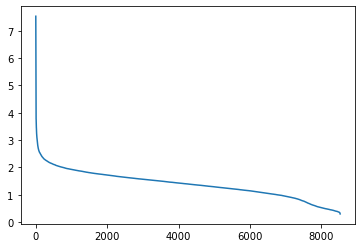

In [77]:
# Determining optimal value of eps Label 3
# Min_samples set to ln(number of points)
min_samples_set = int(math.ceil(math.log(len(X3))))
nbrs = NearestNeighbors(n_neighbors=min_samples_set).fit(X3)
distances, indices = nbrs.kneighbors(X3)
distanceDec = sorted(distances[:,min_samples_set-1], reverse=True)
plt.plot(list(range(1,len(X3) + 1)), distanceDec)

[-1  0]


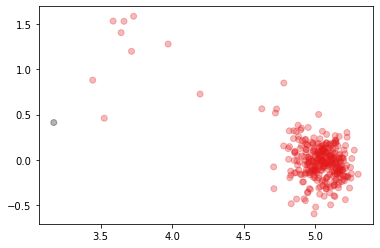

In [82]:
min_samples_set = int(math.ceil(math.log(len(X0))))
db = DBSCAN(eps=1.83, min_samples=min_samples_set).fit(X0)
labels = db.labels_
svd = TruncatedSVD(n_components = 2)
reduced_data_0 = svd.fit_transform(X0)
print(np.unique(labels))
colors = get_cluster_colors(labels)
plt.scatter(reduced_data_0[:,0], reduced_data_0[:,1], c=colors, alpha=0.3)

In [84]:
# Dividing based on DB Scan
df_0 =  df_0[:-1]
df_0['DBScan_Labels'] = labels

df_0_0 = df_0[df_0.DBScan_Labels == 0]
temp_0_0 = pd.DataFrame(pd.Series(' '.join(df_0_0['Cleaned_Email']).split()).value_counts()[:20].sort_values())

df_0_1 = df_0[df_0.DBScan_Labels == 1]
temp_0_1 = pd.DataFrame(pd.Series(' '.join(df_0_1['Cleaned_Email']).split()).value_counts()[:20].sort_values())

df_0_2 = df_0[df_0.DBScan_Labels == 2]
temp_0_2 = pd.DataFrame(pd.Series(' '.join(df_0_2['Cleaned_Email']).split()).value_counts()[:20].sort_values())

df_0_3 = df_0[df_0.DBScan_Labels == 3]
temp_0_3 = pd.DataFrame(pd.Series(' '.join(df_0_3['Cleaned_Email']).split()).value_counts()[:20].sort_values())

df_0_4 = df_0[df_0.DBScan_Labels == 4]
temp_0_4 = pd.DataFrame(pd.Series(' '.join(df_0_4['Cleaned_Email']).split()).value_counts()[:20].sort_values())

ValueError: Length of values (327) does not match length of index (322)

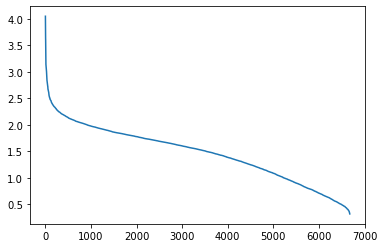

In [70]:
# Determining optimal value of eps Label 1

# Min_samples set to ln(number of points)
min_samples_set = int(math.ceil(math.log(len(X1))))
nbrs = NearestNeighbors(n_neighbors=min_samples_set).fit(X1)
distances, indices = nbrs.kneighbors(X1)
distanceDec = sorted(distances[:,min_samples_set-1], reverse=True)
plt.plot(list(range(1,len(X1) + 1)), distanceDec)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76]


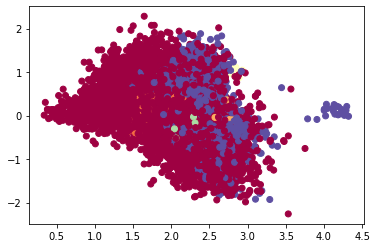

In [71]:
min_samples_set = int(math.ceil(math.log(len(X1))))
db = DBSCAN(eps=1.3, min_samples=min_samples_set).fit(X1)
labels = db.labels_
svd = TruncatedSVD(n_components = 2)
reduced_data_1 = svd.fit_transform(X1)
print(np.unique(labels))
plt.scatter(reduced_data_1[:,0], reduced_data_1[:,1], c=[plt.cm.spectral(float(i) /10) for i in labels])

In [ ]:
# Dividing based on DB Scan
df_1 =  df_1[:-1]
df_1['DBScan_Labels'] = labels

df_1_0 = df_1[df_1.DBScan_Labels == 0]
temp_1_0 = pd.DataFrame(pd.Series(' '.join(df_1_0['Cleaned_Email']).split()).value_counts()[:20].sort_values())

df_1_1 = df_1[df_1.DBScan_Labels == 1]
temp_1_1 = pd.DataFrame(pd.Series(' '.join(df_1_1['Cleaned_Email']).split()).value_counts()[:20].sort_values())

df_1_2 = df_1[df_1.DBScan_Labels == 2]
temp_1_2 = pd.DataFrame(pd.Series(' '.join(df_1_2['Cleaned_Email']).split()).value_counts()[:20].sort_values())

df_1_3 = df_1[df_1.DBScan_Labels == 3]
temp_1_3 = pd.DataFrame(pd.Series(' '.join(df_1_3['Cleaned_Email']).split()).value_counts()[:20].sort_values())
